#### Mempersiapkan Library

In [1]:
import pandas as pd
import numpy as np
import re
import csv
from string import punctuation
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import pickle

#### Mempersiapkan Dataset

In [2]:
tsv_file_path = "train_preprocess.tsv.txt"

data_text = []
label = []

with open(tsv_file_path, encoding='utf-8') as tsvfile:
    tsv_reader = csv.reader(tsvfile, delimiter='\t')
    for row in tsv_reader:
        data_text.append(row[0])
        label.append(row[1])

df = pd.DataFrame({'data_text': data_text, 'label': label})

In [3]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [4]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(7040, 2)
(2200, 2)
(1760, 2)


In [5]:
print('Komposisi Label train_data:')
print(train_data['label'].value_counts())

print('Komposisi Label test_data:')
print(test_data['label'].value_counts())

print('Komposisi Label val_data:')
print(val_data['label'].value_counts())

Komposisi Label train_data:
positive    4134
negative    2185
neutral      721
Name: label, dtype: int64
Komposisi Label test_data:
positive    1272
negative     688
neutral      240
Name: label, dtype: int64
Komposisi Label val_data:
positive    1010
negative     563
neutral      187
Name: label, dtype: int64


#### Normalisasi Text

In [6]:
def lowercasing(paragraph):
    return paragraph.lower()

In [7]:
def menghilangkan_tandabaca(paragraph):
    new_paragraph = re.sub(fr'[{punctuation}]', r'', paragraph)
    return new_paragraph

In [8]:
def text_normalization(paragraph):
    paragraph = lowercasing(paragraph)
    paragraph = menghilangkan_tandabaca(paragraph)
    paragraph = re.sub(r"[ ]+",r' ',paragraph)
    return paragraph

In [9]:
train_data['data_text'] = train_data['data_text'].apply(lambda x: text_normalization(x))
test_data['data_text'] = test_data['data_text'].apply(lambda x: text_normalization(x))
val_data['data_text'] = val_data['data_text'].apply(lambda x: text_normalization(x))

#### Training Model

In [10]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [11]:
tokenizer.fit_on_texts(train_data['data_text'])

In [12]:
train_data_tf = tokenizer.texts_to_sequences(train_data['data_text'])
test_data_tf = tokenizer.texts_to_sequences(test_data['data_text'])
val_data_tf = tokenizer.texts_to_sequences(val_data['data_text'])

In [13]:
train_data['data_text']

4057     indihome gangguan terus bayar nya saja mahal t...
7811     tempat pemandangan nya luar biasa dan pelayana...
5046     bagaimana kalau netizen pada patungan menyewa ...
7404                                           tidak sehat
8055     ulah sendiri kok gubernur yang disalahkan dasa...
                               ...                        
10959                  saya cemburu tapi tidak bisa apaapa
3997     bubarkan saja dpr rakyat tidak butuh diwakili ...
4118     steak di sini selalu membuat ketagihan menu ke...
5646                                      adit kayak tarik
10675    restoran sumoamg padang dago adalah palung pop...
Name: data_text, Length: 7040, dtype: object

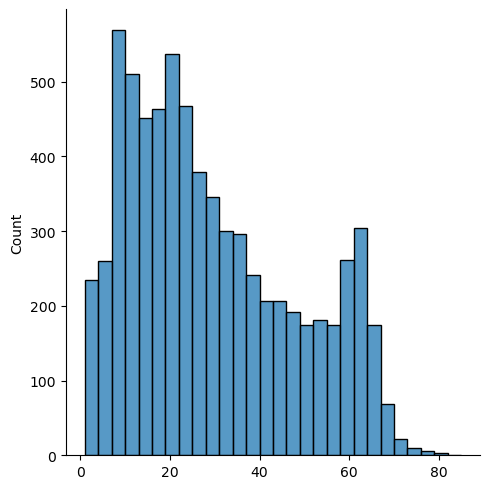

In [14]:
sns.displot([len(x) for x in train_data_tf])

In [15]:
max_len = int(np.quantile([len(x) for x in train_data_tf], 0.9))

In [16]:
max_len

59

In [17]:
train_padded = pad_sequences(sequences = train_data_tf, padding='post', maxlen=max_len)
test_padded = pad_sequences(sequences = test_data_tf, padding='post', maxlen=max_len)
val_padded = pad_sequences(sequences = val_data_tf, padding='post', maxlen=max_len)

In [18]:
print(train_padded.shape)
print(test_padded.shape)
print(val_padded.shape)

(7040, 59)
(2200, 59)
(1760, 59)


In [19]:
onehot = OneHotEncoder()

In [20]:
onehot.fit_transform(train_data[['label']])

<7040x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7040 stored elements in Compressed Sparse Row format>

In [21]:
train_labels = onehot.fit_transform(train_data[['label']]).toarray()

#### Model Testing and Evaluation

In [22]:
model = Sequential()

In [23]:
max_features = len(tokenizer.index_word)
batch_size=16
output_dim = 64
input_len = max_len

In [24]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                           output_dim=output_dim,
                           input_length=input_len))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [26]:
maximum_index_training = int(np.floor(train_padded.shape[0]/batch_size)*batch_size)
model.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_size, 
          epochs=20, 
          shuffle=False)

Epoch 1/20
440/440 [==============================] - 18s 36ms/step - loss: 0.8700 - accuracy: 0.6161
Epoch 2/20
440/440 [==============================] - 16s 36ms/step - loss: 0.6728 - accuracy: 0.7406
Epoch 3/20
440/440 [==============================] - 16s 36ms/step - loss: 0.6387 - accuracy: 0.7540
Epoch 4/20
440/440 [==============================] - 16s 36ms/step - loss: 0.6154 - accuracy: 0.7750
Epoch 5/20
440/440 [==============================] - 16s 36ms/step - loss: 0.5691 - accuracy: 0.7847
Epoch 6/20
440/440 [==============================] - 16s 36ms/step - loss: 0.4811 - accuracy: 0.8094
Epoch 7/20
440/440 [==============================] - 16s 36ms/step - loss: 0.3723 - accuracy: 0.8483
Epoch 8/20
440/440 [==============================] - 16s 36ms/step - loss: 0.2851 - accuracy: 0.8849
Epoch 9/20
440/440 [==============================] - 16s 36ms/step - loss: 0.1963 - accuracy: 0.9295
Epoch 10/20
440/440 [==============================] - 16s 36ms/step - loss: 0.122

In [27]:
y_pred = model.predict(val_padded,batch_size=1)

1760/1760 [==============================] - 11s 6ms/step


In [28]:
y_pred = onehot.inverse_transform(y_pred).reshape(-1)

In [29]:
accuracy_score(y_pred=y_pred, y_true=val_data['label'])

0.8517045454545454

In [30]:
pickle.dump(model, open('model_LSTM.h5','wb'))